Notebook for plotting behavior related to Rachel Wahlberg circular maze task.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    assert False, 'plot_dir not yet implemented on Nat laptop'
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
import matplotlib as mpl
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

from neuropy import plotting

from neuropy.analyses.placefields import Pf1D
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
# Import CircularPosition class
sys.path.extend(['/data3/Rachel/Recording_Rats/'])
from circularPosition import CircularPosition

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [26]:
base_dir = Path("/data2/Rachel_Task/Behavior_Rats")
dean_dict = {"TaskTraining1": {"sesh1": {"dir": base_dir / "Dean" / "2025_03_13_TaskTraining1", "old_ports": [None, None], 
                                         "new_ports": [2, 3], "start_time": "13_26_37"}},
             "TaskTraining2": {"sesh1": {"dir": base_dir / "Dean" / "2025_03_14_TaskTraining2" / "1_session1", "old_ports": [2, 3],
                                         "new_ports": [0, 1], "start_time": "12_09_35"}, 
                               "sesh2": {"dir": base_dir / "Dean" / "2025_03_14_TaskTraining2" / "2_session2", "old_ports": [2, 3],
                                         "new_ports": [0, 1], "start_time": "16_59_56"}
                              }
            }
seamus_dict = {"TaskTraining1": {"sesh1": {"dir": base_dir / "Seamus" / "2025_03_13_TaskTraining1", "old_ports": [None, None],
                                           "new_ports": [0, 1], "start_time": "12_07_54"}},
               "TaskTraining2": {"sesh1": {"dir": base_dir / "Seamus" / "2025_04_03_TaskTraining2" / "session1", "old_ports": [0, 1],
                                           "new_ports": [2, 3], "start_time": "14_15_46"}}, 
               "TaskTraining3": {"sesh1": {"dir": base_dir / "Seamus" / "2025_04_04_TaskTraining3" / "session1", "old_ports": [2, 3],
                                           "new_ports": [0, 1], "start_time": "11_45_51"}}
              }

neville_dict = {"TaskTraining1": {"sesh1": {"dir": base_dir / "Neville" / "2025_03_14_TaskTraining1", "old_ports": [None, None],
                                            "new_ports": [0, 1], "start_time": "11_03_02"}}}

sessions = {"Dean": dean_dict, "Seamus": seamus_dict, "Neville": neville_dict}
neville_dict["TaskTraining1"]["sesh1"]["dir"].exists()

True

In [12]:
# Load in port visits as dataframe - make into function
import re as re
def load_session_data(animal, day_alias, session_num, session_dict=sessions):
    sesh_use = sessions[animal][day_alias][session_num]
    dir_use, old_ports, new_ports = [sesh_use[key] for key in ["dir", "old_ports", "new_ports"]]
    sesh_date = re.search("[0-9][0-9][0-9][0-9]-[0-1][0-9]-[0-3][0-9]",sorted(dir_use.glob("portTimestamps*"))[0].name).group(0)
    port_df_list = []
    for file_use in sorted(dir_use.glob("portTimestamps*")):
        port_df = pd.read_csv(file_use, header=None, delimiter=" ").drop(columns=[0, 3])
        port_df = port_df.rename(columns={1: "Timestamp", 2: "port"})
        port_df_comb = port_df_list.append(port_df)
    port_df = pd.concat(port_df_list, axis=0, ignore_index=True)

    for attrname, attr in zip(["dir", "old_ports", "new_ports"], [dir_use, old_ports, new_ports]):
        port_df.attrs[attrname] = attr
    
    return port_df

animal, session, subsesh = "Seamus", "TaskTraining3", "sesh1"
sesh_use = sessions[animal][session][subsesh]
port_df = load_session_data(animal, session, subsesh)
active_ports = port_df.attrs["new_ports"]
old_ports = port_df.attrs["old_ports"]
port_df.head(6)

,Timestamp,port
0,11:47:41:548,1
1,11:47:51:877,0
2,11:48:07:425,2
3,11:48:08:416,3
4,11:48:20:217,2
5,11:48:27:618,0


In [19]:
active_ports

[0, 1]

In [20]:
old_ports

[2, 3]

In [22]:
def get_trials(port_df_in, active_ports, old_ports, start_time):
    sesh_df = deepcopy(port_df_in)

    # Find visits to active ports
    active_port_bool = sesh_df.port.isin(active_ports)  # get visits to active ports
    active_diff = sesh_df.port[active_port_bool]

    # Determine correct vists to active ports
    correct = active_diff.diff().abs() == 1
    correct[0] = True  # set first port visit to True
    sesh_df["correct"] = correct
    sesh_df.loc[~active_port_bool, "correct"] = False  # Set visits to non-active ports to False

    # Find visits to old ports
    old_port_bool = sesh_df.port.isin(old_ports)  
    sesh_df["old port"] = old_port_bool

    # Find visits to other ports
    other_port_bool = (~old_port_bool) & (~active_port_bool)
    sesh_df["other port"] = other_port_bool

    # Last, get times from beginning of session for each
    tot_sec = (pd.to_timedelta([".".join([":".join(ts.split(":")[0:3]), ts.split(":")[3]]) for ts in sesh_df["Timestamp"]]) 
               - pd.to_timedelta(":".join(start_time.split("_")))).total_seconds()
    sesh_df["Time from start (s)"] = tot_sec
    
    return sesh_df

sesh_df = get_trials(port_df, active_ports, old_ports, sesh_use["start_time"])
sesh_df


,Timestamp,port,correct,old port,other port,Time from start (s)
0,11:04:05:358,1,True,False,False,-3828.642
1,11:05:33:508,2,False,True,False,-3740.492
2,11:06:20:227,5,False,False,True,-3693.773
3,11:06:32:939,2,False,True,False,-3681.061
4,11:06:37:757,1,False,False,False,-3676.243
...,...,...,...,...,...,...
123,11:50:45:887,1,True,False,False,-1028.113
124,11:50:56:111,0,True,False,False,-1017.889
125,11:51:16:684,1,True,False,False,-997.316
126,11:51:40:721,0,True,False,False,-973.279


### Start with Dean behavioral data

#### Plot example session to check

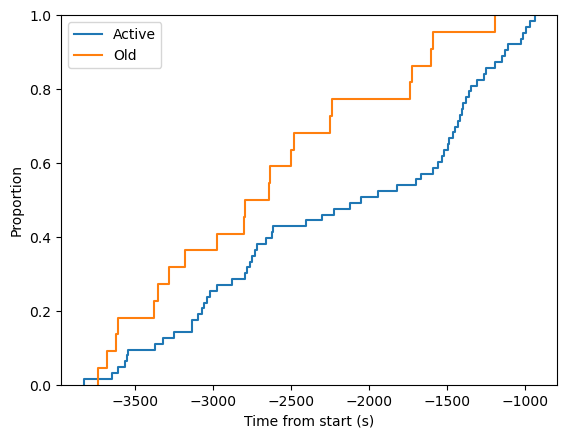

In [23]:
_, ax = plt.subplots()
sns.ecdfplot(data=sesh_df[sesh_df.correct == 1], x="Time from start (s)", ax=ax)
sns.ecdfplot(data=sesh_df[sesh_df["old port"]], x="Time from start (s)", ax=ax)
plt.legend(["Active", "Old"])

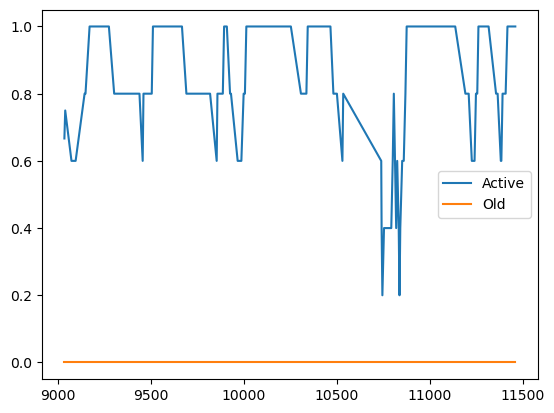

In [256]:
_, ax = plt.subplots()
hc, = ax.plot(sesh_df["Time from start (s)"], sesh_df["correct"].rolling(5, min_periods=3).mean())
hold, = ax.plot(sesh_df["Time from start (s)"], sesh_df["old port"].rolling(5, min_periods=3).mean())
plt.legend([hc, hold], ["Active", "Old"])

[Text(0, 0, 'Correct'), Text(0, 1, 'Incorrect')]

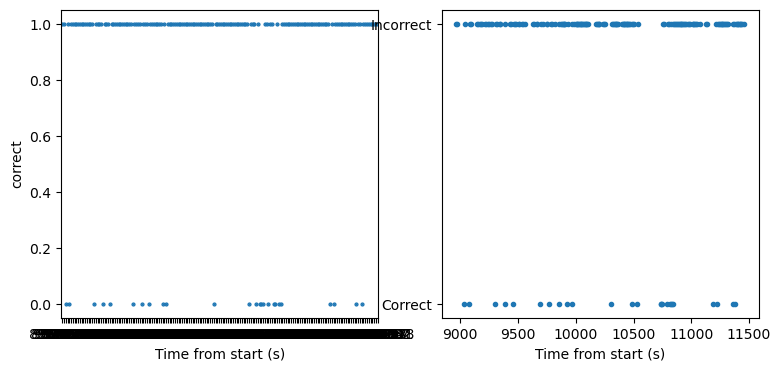

In [257]:
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.pointplot(data=sesh_df, x="Time from start (s)", y="correct", linestyle="none", marker='.', markersize=2, ax=ax[0])
sns.pointplot(data=sesh_df[sesh_df["old port"]], x="Time from start (s)", y="correct", linestyle="none", marker='.', markersize=2,
              ax=ax[0])
df_corr, df_old = sesh_df[sesh_df["correct"]], sesh_df[sesh_df["old port"]]
ax[1].plot(sesh_df["Time from start (s)"], sesh_df["correct"], '.')
ax[1].plot(df_old["Time from start (s)"], df_old["correct"], '.')
ax[1].set_xlabel('Time from start (s)')
ax[1].set_yticks([0, 1])
ax[1].set_yticklabels(["Correct", "Incorrect"])

### Plot all sessions

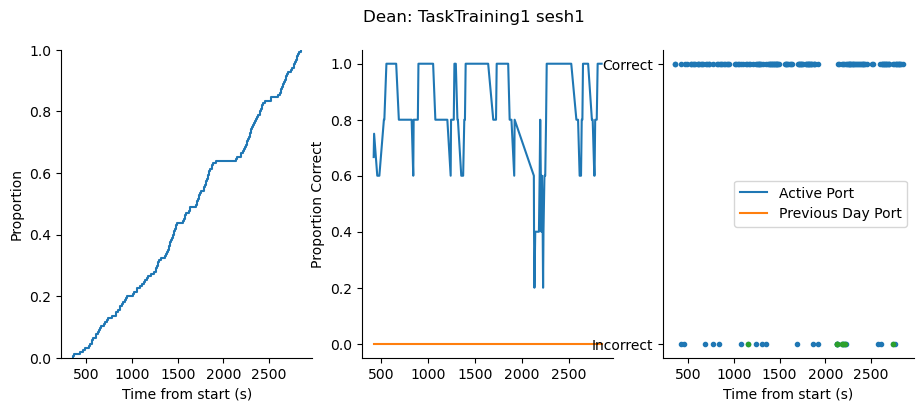

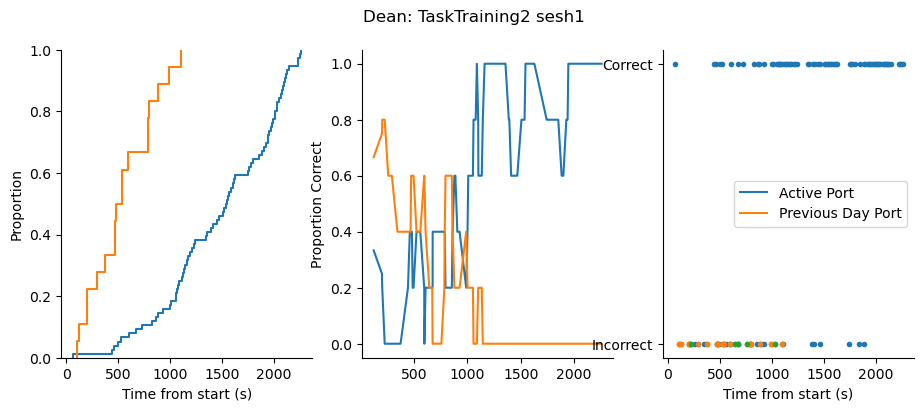

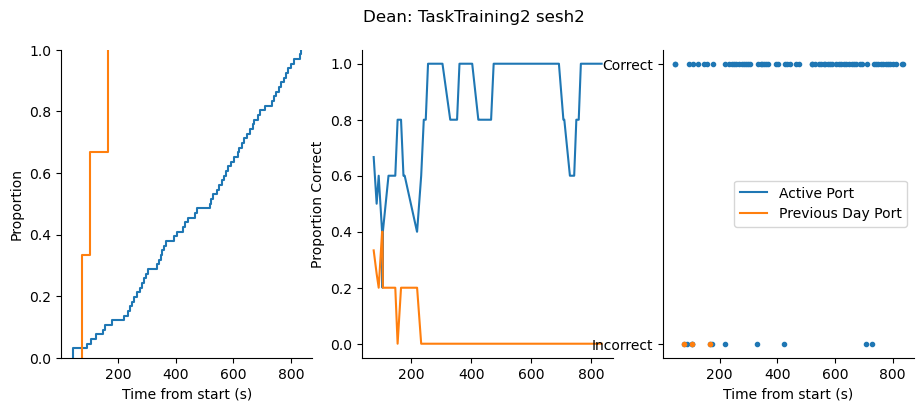

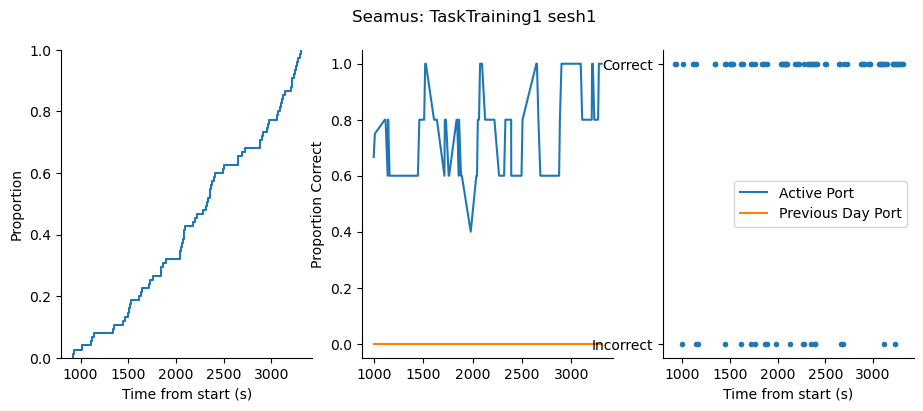

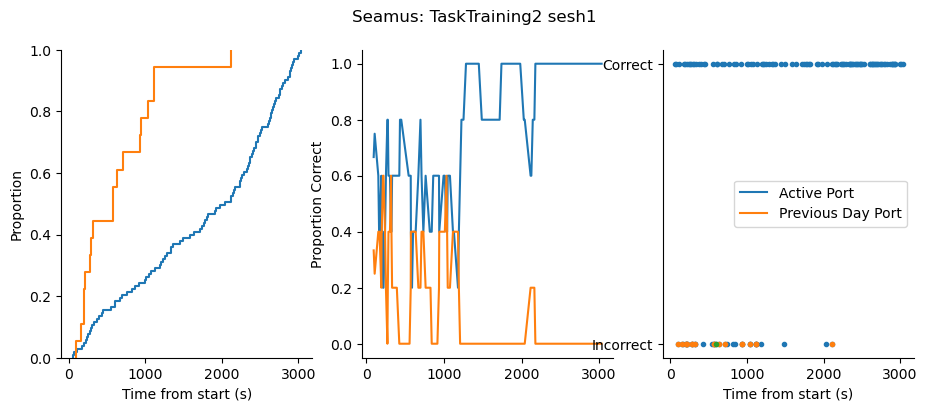

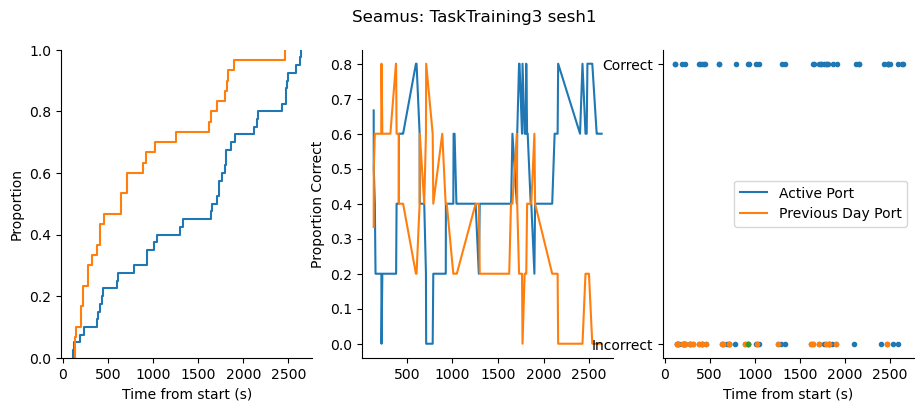

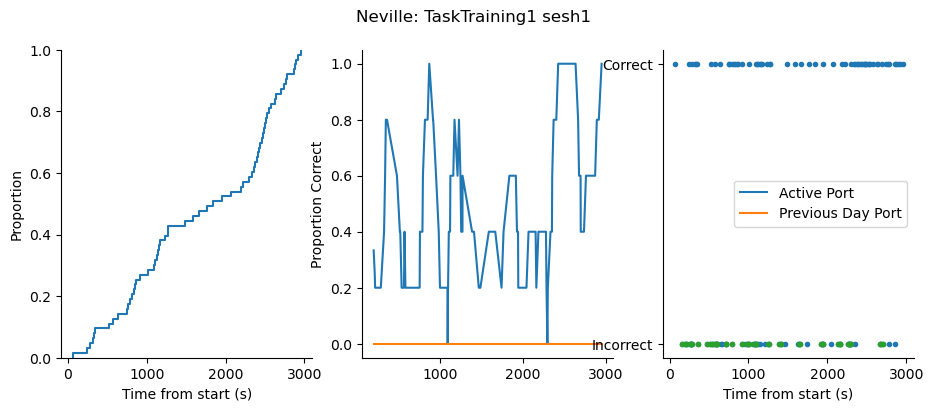

In [27]:
for rat, rat_dict in sessions.items():
    for day_alias, day_dict in rat_dict.items():
        for session, sesh_dict in day_dict.items():
            port_df = load_session_data(rat, day_alias, session)
            sesh_df = get_trials(port_df, sesh_dict["new_ports"], sesh_dict["old_ports"], sesh_dict["start_time"])

            fig, ax = plt.subplots(1, 3, figsize=(11, 4))
            fig.suptitle(f"{rat}: {day_alias} {session}")

            # Plot behavior 1st way
            sns.ecdfplot(data=sesh_df[sesh_df.correct == 1], x="Time from start (s)", ax=ax[0])
            sns.ecdfplot(data=sesh_df[sesh_df["old port"]], x="Time from start (s)", ax=ax[0])
            plt.legend(["Active", "Old"])

            # Plot behavior 2nd way
            hc, = ax[1].plot(sesh_df["Time from start (s)"], sesh_df["correct"].rolling(5, min_periods=3).mean())
            hold, = ax[1].plot(sesh_df["Time from start (s)"], sesh_df["old port"].rolling(5, min_periods=3).mean())
            ax[1].set_ylabel("Proportion Correct")
            plt.legend([hc, hold], ["Active Port", "Previous Day Port"])

            # Plot 3rd way
            df_corr, df_old, df_other = sesh_df[sesh_df["correct"]], sesh_df[sesh_df["old port"]], sesh_df[sesh_df["other port"]]
            ax[2].plot(sesh_df["Time from start (s)"], sesh_df["correct"], '.')
            ax[2].plot(df_old["Time from start (s)"], df_old["correct"], '.')
            ax[2].plot(df_other["Time from start (s)"], df_other["correct"], '.')
            ax[2].set_xlabel('Time from start (s)')
            ax[2].set_yticks([0, 1])
            ax[2].set_yticklabels(["Incorrect", "Correct"])

            sns.despine(fig=fig)

            fig.savefig(plot_dir / "behavior" / f"{rat}_{day_alias}_{session}_behavior.pdf")
            

### Seamus